Spotify API를 통해 획득한 데이터셋을 이용해 genre sentences를 만들고 모델 생성

In [22]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText
import gensim.models as g
from sklearn.manifold import TSNE
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import pickle

In [25]:
def show_tsne(X_show, vocab_show, filename=False):
    tsne = TSNE(n_components=2)
    X = tsne.fit_transform(X_show)

    df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y'])
    fig = plt.figure()
    fig.set_size_inches(30, 20)
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(df['x'], df['y'])

    for word, pos in df.iterrows():
        ax.annotate(word, pos, fontsize=10)

    plt.xlabel("t-SNE 특성 0")
    plt.ylabel("t-SNE 특성 1")
    plt.show()

In [26]:
def center_align(arr):
    aligned_arr = ['0' for i in range(len(arr))]
    center = int((len(arr))/2)
    
    for i in range(len(arr)):
        aligned_arr[center + ((-1)**i) * math.ceil(i/2)] = arr[i]
    
    return aligned_arr

In [27]:
# 장르 리스트를 입력받으면 word vector 내에 있는 vocabulary만 리턴
def make_positive_list(genre_list, model):
    positive_list = []
    for genre in genre_list:
        try:
            model.wv.key_to_index[genre]
            positive_list.append(genre)
        except:
            continue
    
    return positive_list

In [23]:
# Spotify API를 이용해 획득한 json 데이터를 로드
file_path = "./dataset/spotify_dataset.json"

with open(file_path, 'r') as file:
    spotify_data = json.load(file)

In [24]:
# genre - artists로 연결된 json 데이터를 로드
file_path = "./dataset/genre_artists.json"

with open(file_path, 'r') as file:
    genre_artists_json = json.load(file)

In [28]:
origin_genre_sentences = []

for idx, d in enumerate(spotify_data):
    if 'genres' in d:
        if d['popularity'] >= 0:
            if len(d['genres']) > 1:
                origin_genre_sentences.append(d['genres'])


In [30]:
# 각각의 문장의 단어들을 count를 기준으로 중앙 정렬해 center_aligned_sentences으로 입력
center_aligned_sentences = []
for genres in tqdm(origin_genre_sentences):
    tmp_arr = []
    for g in genres:
        for d in genre_artists_json:
            if g == d['genre']:
                tmp_arr.append([g, d['count']])
                break
    tmp_arr.sort(key=lambda x:-x[1])

    sort_arr = []
    for t in tmp_arr:
        sort_arr.append(t[0])
        
    center_aligned_sentences.append(center_align(sort_arr))

100%|███████████████████████████████████| 47023/47023 [00:37<00:00, 1266.79it/s]


In [32]:
#앞서 만든 center_aligned_sentences를 저장
with open('./dataset/origin_genre_sentences.pkl','wb') as f:
    pickle.dump(center_aligned_sentences, f)

In [33]:
wvmodel = Word2Vec(sentences=center_aligned_sentences, vector_size=300, window=5, min_count=10, workers=4, sg=1, epochs=5)

In [34]:
wvmodel.wv.save('./model/genres_w5.model')

In [35]:
vocab = wvmodel.wv.key_to_index

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


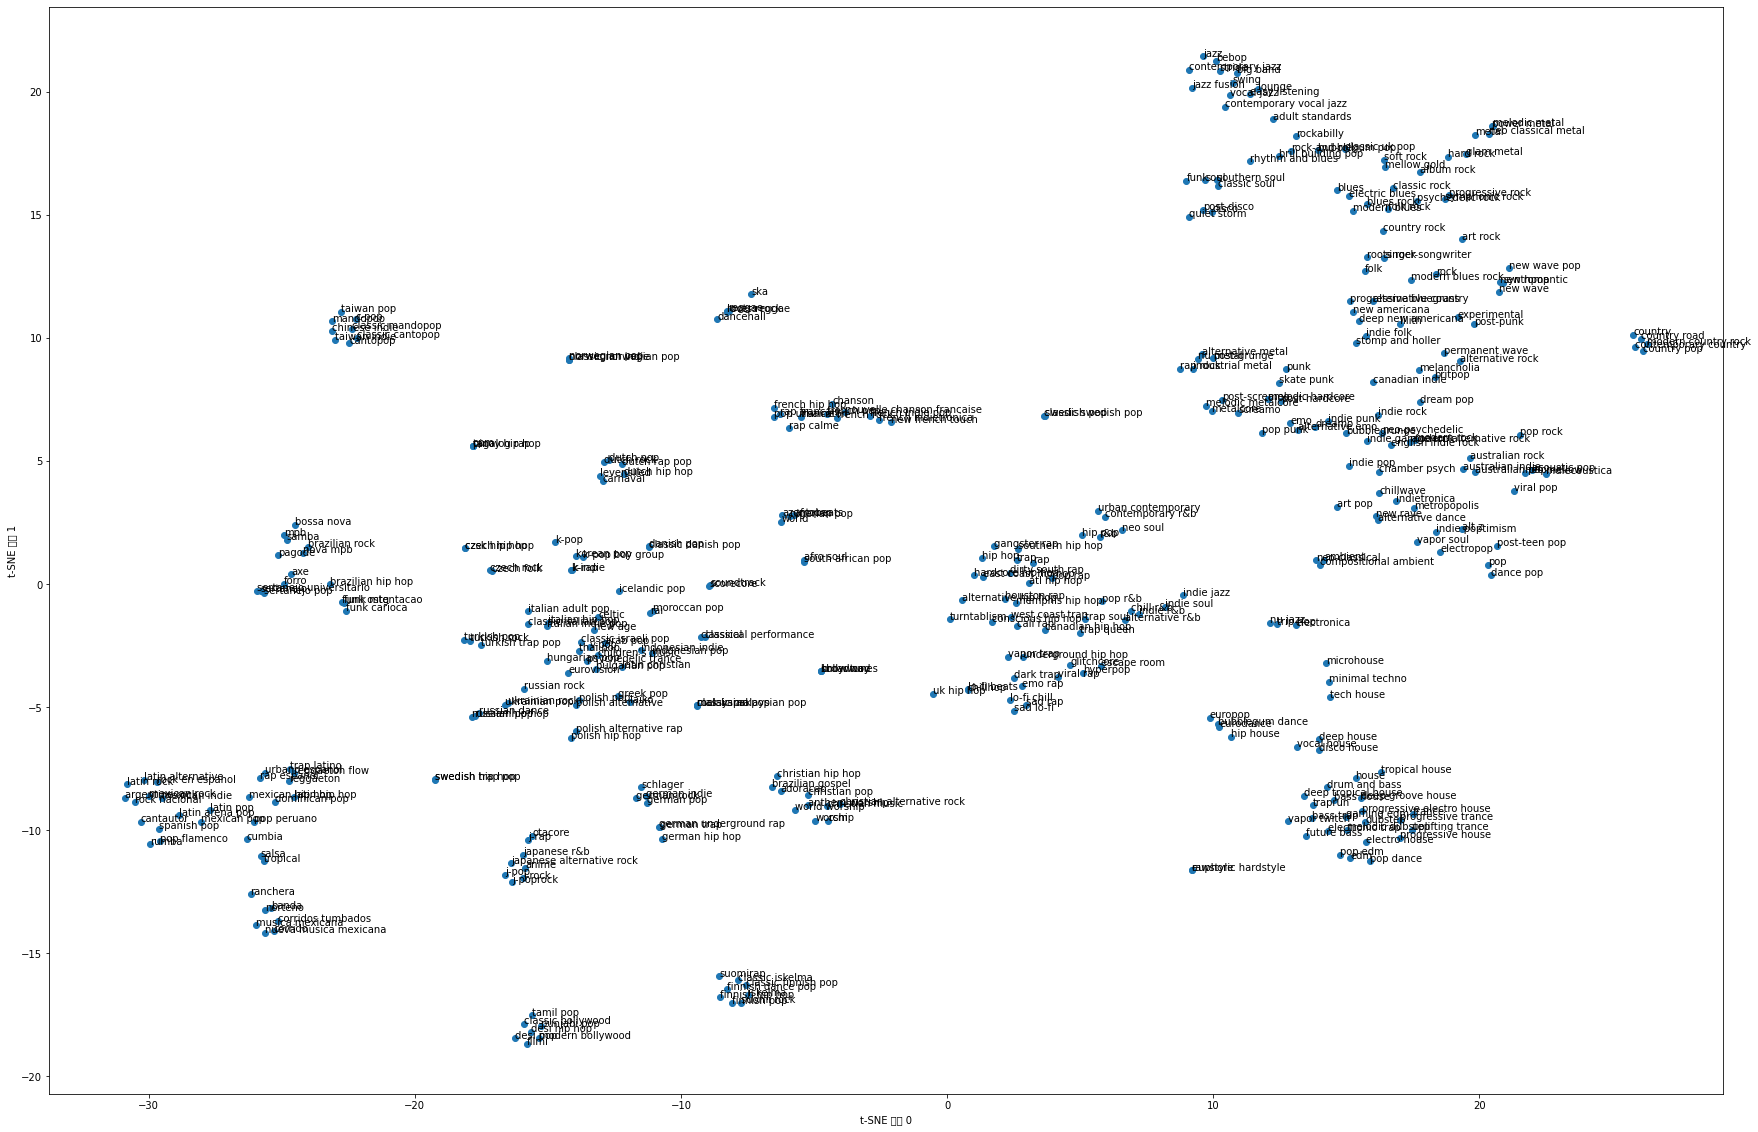

In [36]:
X = wvmodel.wv[vocab]
size = 400
X_show = X[:size, :]
vocab_show = list(vocab.keys())[:size]

show_tsne(X_show, vocab_show)